In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
import os.path
import glob
import math as m
import methods
import line

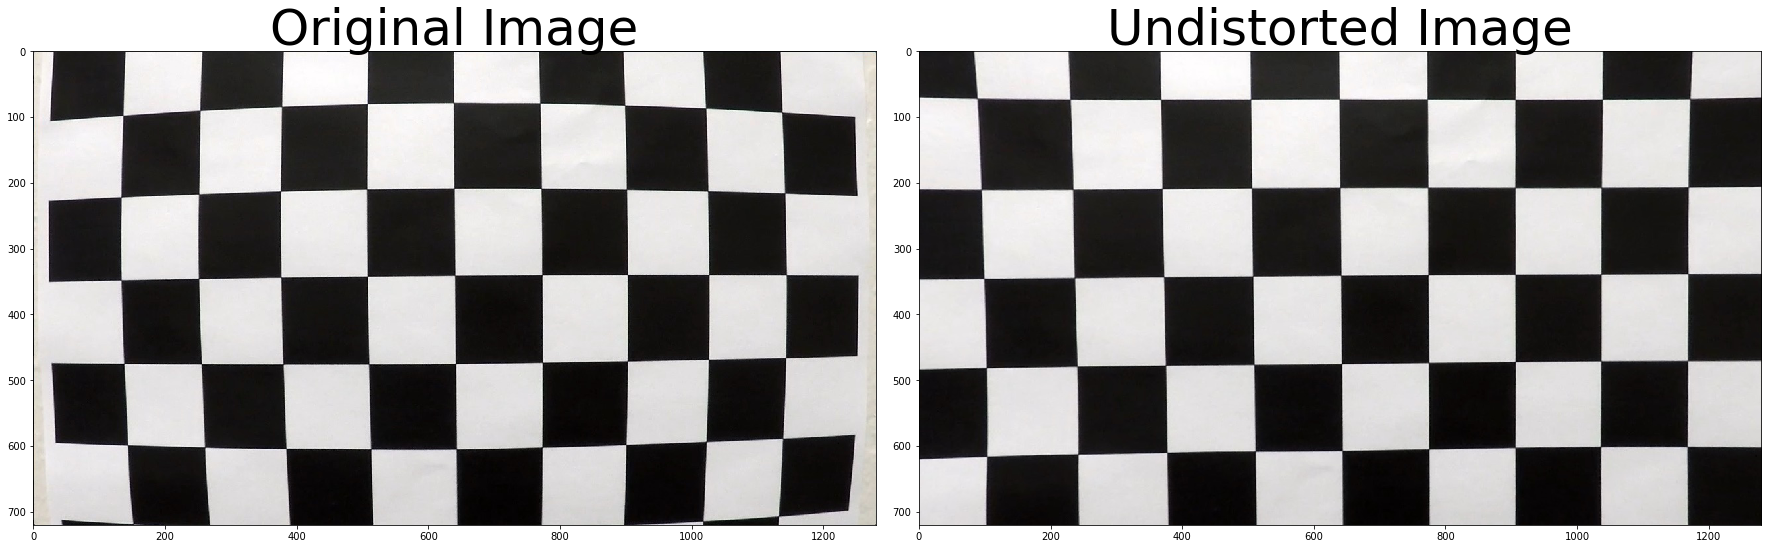

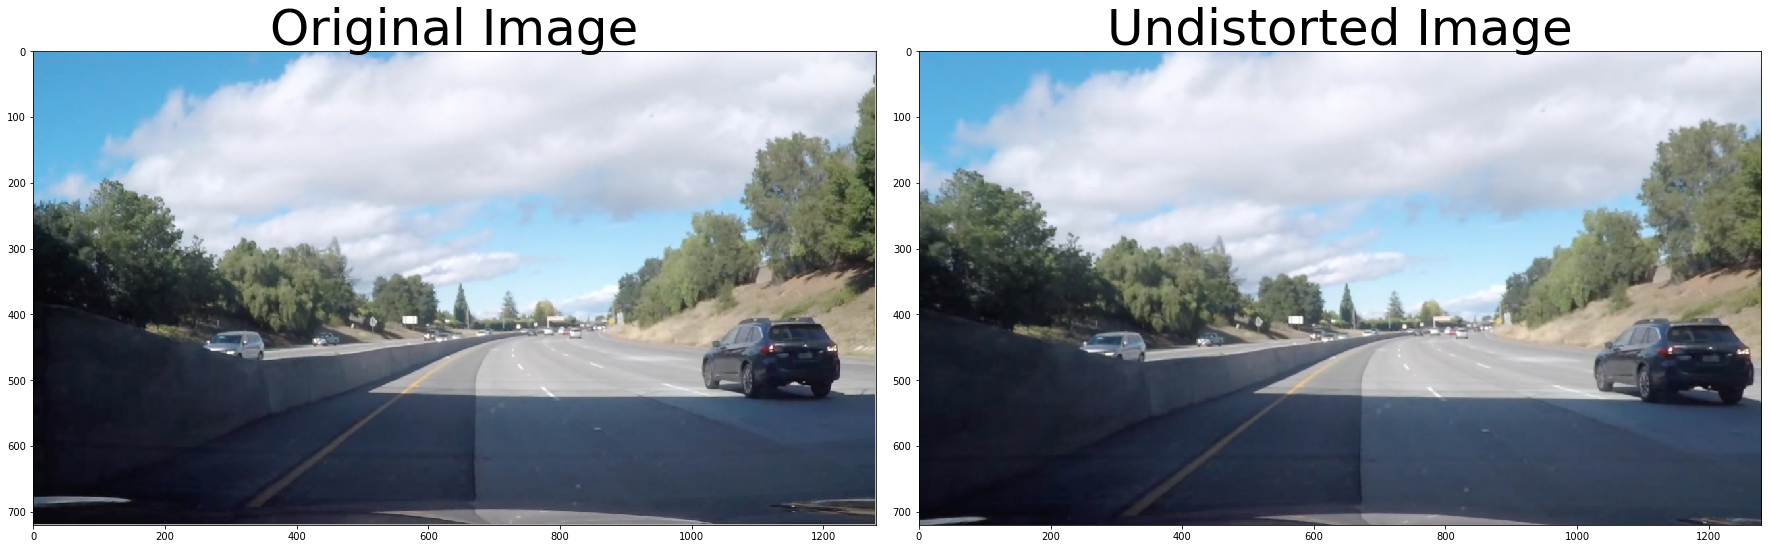

In [152]:
def show_und(img, undistorted):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 

%matplotlib inline
obj_points, img_points = methods.read_points(rewrite=False, show=False)
# Show train result
img = cv2.imread('./camera_cal/calibration1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted = methods.cal_undistort(img, obj_points, img_points)
show_und(img, undistorted)
# Show test result
img = cv2.imread('./test_images/shadow2.jpg')
img = cv2.resize(img, (1280, 720)) 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted = methods.cal_undistort(img, obj_points, img_points)
show_und(img, undistorted)

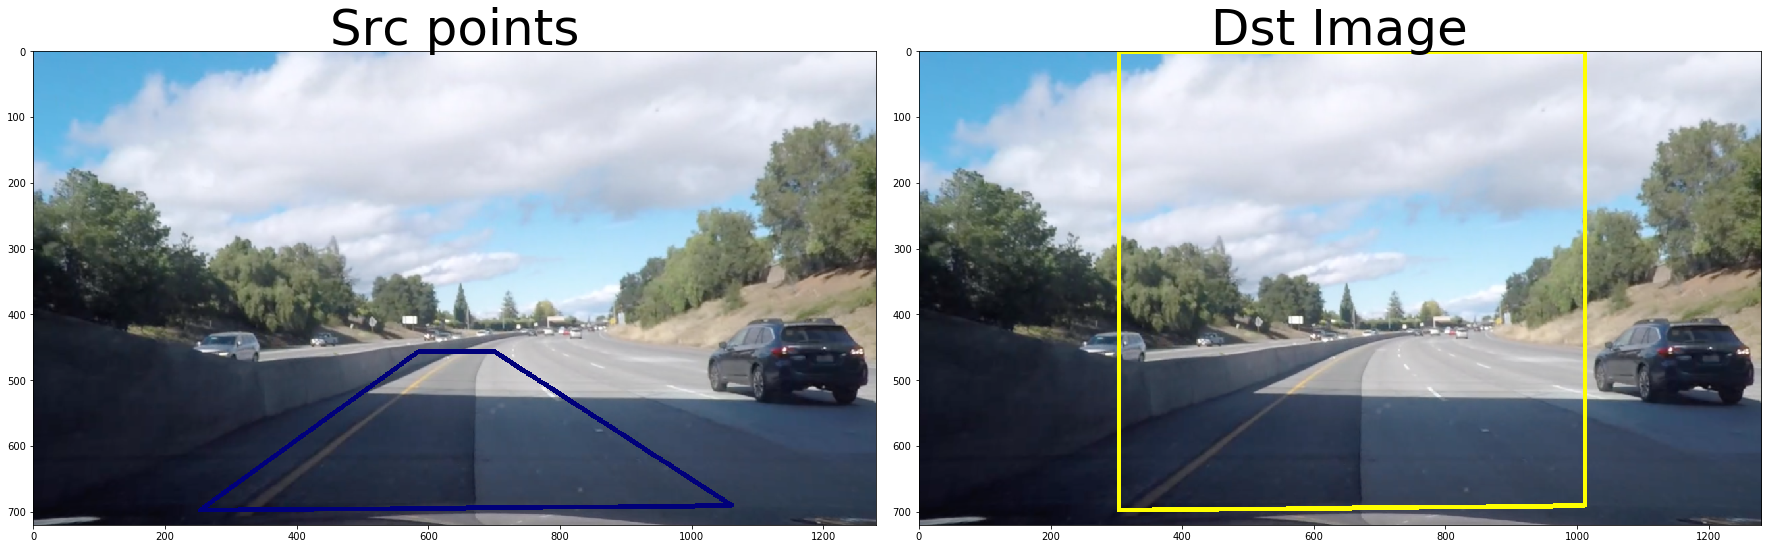

In [153]:
img = undistorted

w = img.shape[1]
h = img.shape[0]

src_img = img.copy()
dst_img = img.copy()

# corners = np.float32([[150, 650], [300, 500], [1050, 500], [1200, 650]])
corners = np.float32([[253, 697], [585, 456], [700, 456], [1061, 690]])
new_top_left = np.array([corners[0, 0], 0])
new_top_right = np.array([corners[3, 0], 0])
offset = [50, 0]
src = np.float32([corners[0], corners[1], corners[2], corners[3]])
dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])
cv2.polylines(src_img, np.int32([src]), True, (0, 0, 122), thickness=5)
cv2.polylines(dst_img, np.int32([dst]), True, (255, 255, 0), thickness=5)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(src_img)
ax1.set_title('Src points', fontsize=50)
ax2.imshow(dst_img)
ax2.set_title('Dst Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

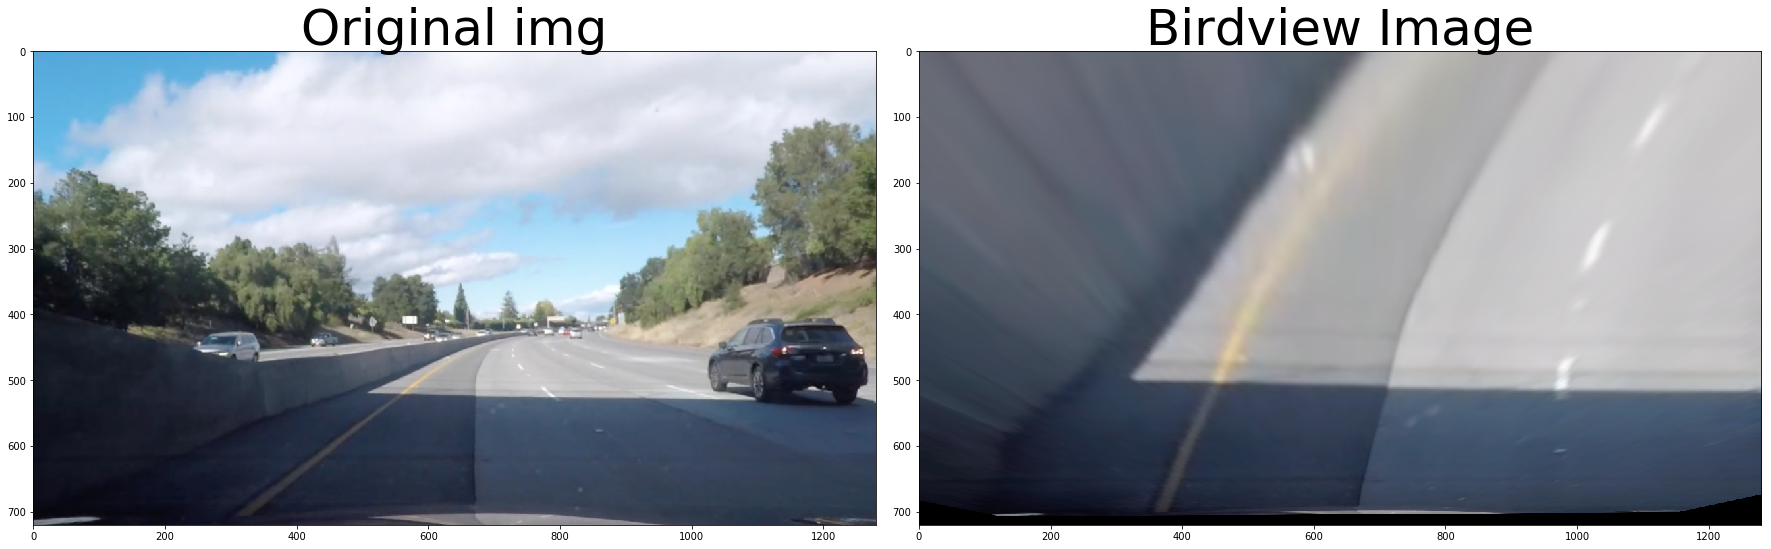

In [154]:
tr_img, t_m, inv_m = methods.perspective_tr(img, src, dst, (img.shape[1], img.shape[0]))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original img', fontsize=50)
ax2.imshow(tr_img)
ax2.set_title('Birdview Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

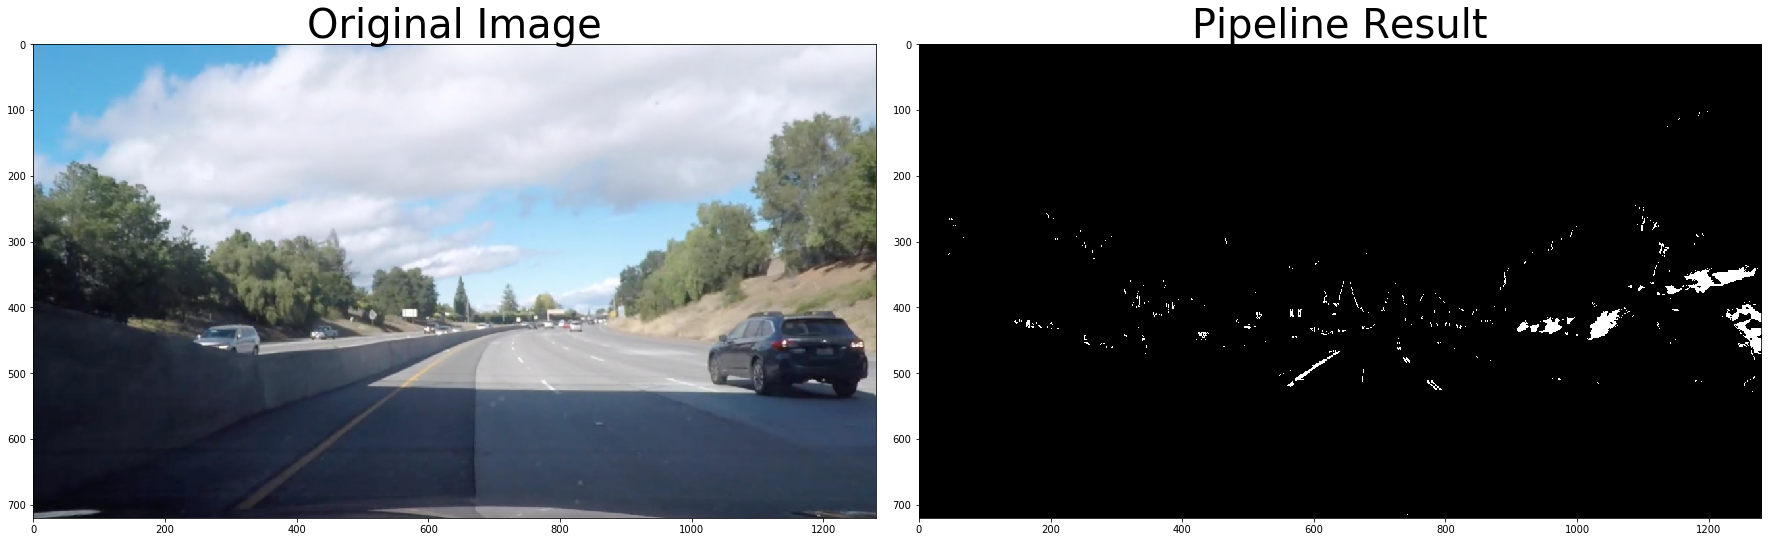

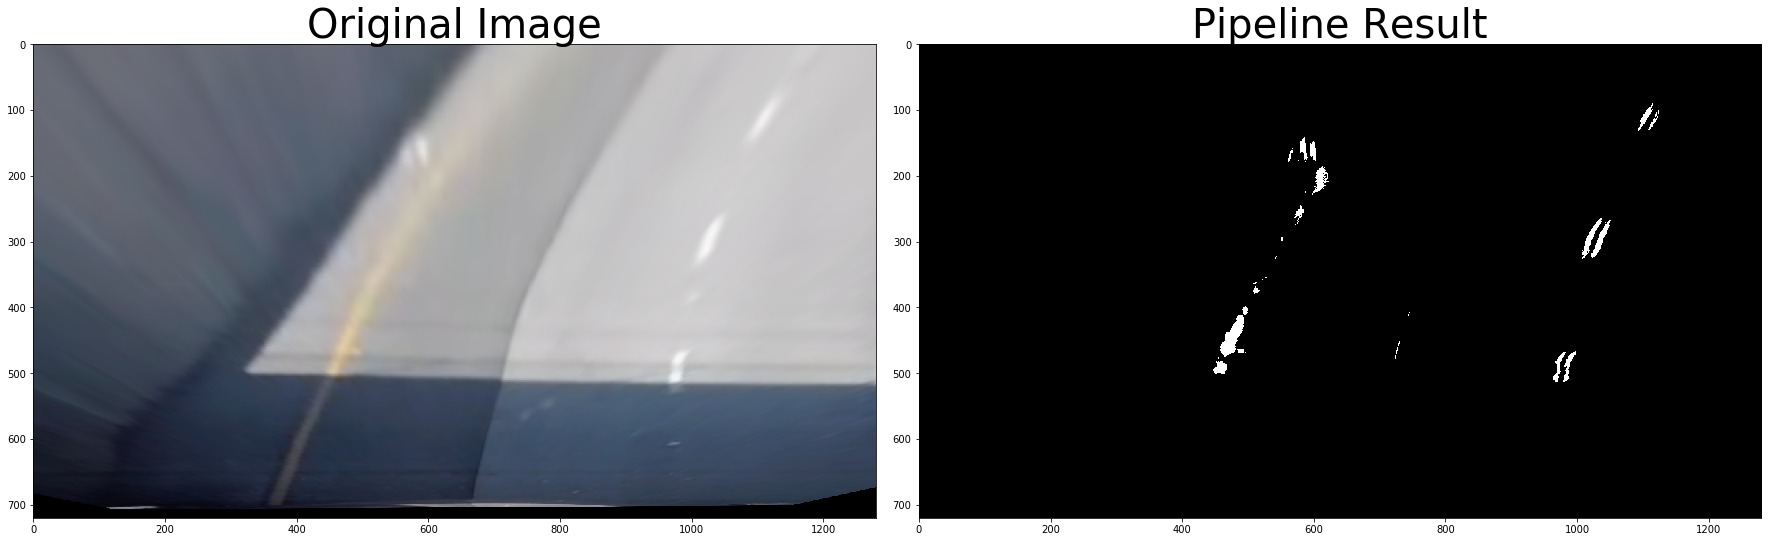

In [156]:
def score_pixels(img) -> np.ndarray:
    """
    Takes a road image and returns an image where pixel intensity maps to likelihood of it being part of the lane.

    Each pixel gets its own score, stored as pixel intensity. An intensity of zero means it is not from the lane,
    and a higher score means higher confidence of being from the lane.

    :param img: an image of a road, typically from an overhead perspective.
    :return: The score image.
    """
    # Settings to run thresholding operations on
    settings = [{'name': 'lab_b', 'cspace': 'LAB', 'channel': 2, 'clipLimit': 2.0, 'threshold': 150},
                {'name': 'value', 'cspace': 'HSV', 'channel': 2, 'clipLimit': 6.0, 'threshold': 190},
                {'name': 'lightness', 'cspace': 'HLS', 'channel': 1, 'clipLimit': 2.0, 'threshold': 200}]

    # Perform binary thresholding according to each setting and combine them into one image.
    scores = np.zeros(img.shape[0:2]).astype('uint8')
    for params in settings:
        # Change color space
        color_t = getattr(cv2, 'COLOR_RGB2{}'.format(params['cspace']))
        gray = cv2.cvtColor(img, color_t)[:, :, params['channel']]

        # Normalize regions of the image using CLAHE
        clahe = cv2.createCLAHE(params['clipLimit'], tileGridSize=(8, 8))
        norm_img = clahe.apply(gray)

        # Threshold to binary
        ret, binary = cv2.threshold(norm_img, params['threshold'], 1, cv2.THRESH_BINARY)

        scores += binary

        # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)  # Take the derivative in x
    abs_sobelx = np.absolute(sobelx)  # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= 20) & (scaled_sobel <= 100)] = 1

    scores += sxbinary

    combined_binary = np.zeros_like(scores)
    combined_binary[scores > 2] = 1

    #         return cv2.normalize(scores, None, 0, 255, cv2.NORM_MINMAX)
    return combined_binary

result = score_pixels(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

result = score_pixels(tr_img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(tr_img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

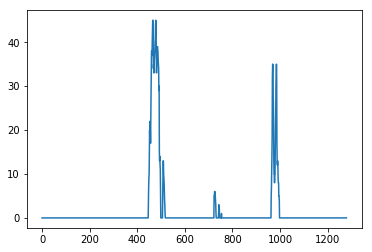

In [157]:
histogram = np.sum(result[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)
binary_warped = result

True

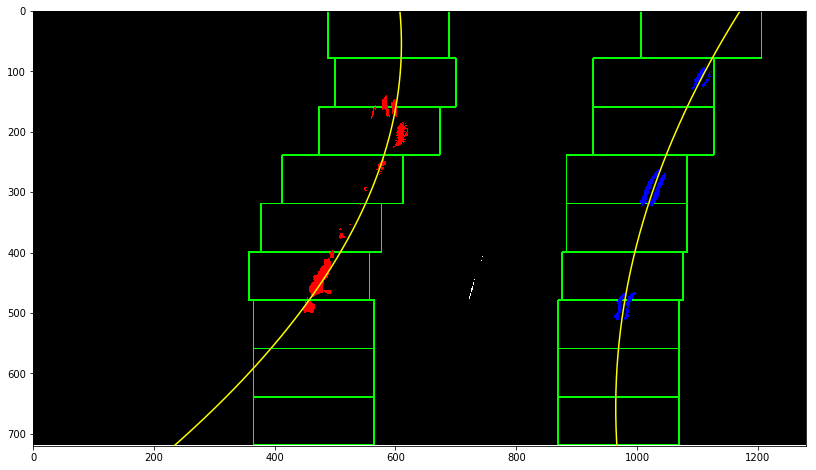

In [158]:
# left_fit, right_fit, l, r, d, la, ra, out_img = lane_lines(result, visualise=True)
left_fit, right_fit, l, r, d, la, ra, out_img = methods.lane_lines(result, visualise = True)
left_fitx, right_fitx, ploty = methods.fit_lanes(out_img, left_fit, right_fit)
plt.figure(figsize=(16,8))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
cv2.imwrite('output_images/sliding_window.png', out_img)


In [148]:
# left_fit, right_fit, l, r, d, la, ra = lane_lines2(result, left_fit, right_fit)
left_fit, right_fit,l, r, d, la, ra = methods.lane_lines2(result, left_fit, right_fit)
left_fitx, right_fitx, ploty = methods.fit_lanes(result, left_fit, right_fit)

True

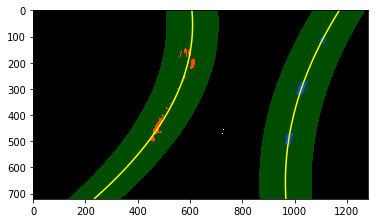

In [159]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((result, result, result))*255

nonzero = result.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

margin = 100
left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy +
                               left_fit[2] - margin)) & (nonzerox < (left_fit[0] * (nonzeroy ** 2) +
                                                                     left_fit[1] * nonzeroy + left_fit[
                                                                         2] + margin)))

right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy +
                                right_fit[2] - margin)) & (nonzerox < (right_fit[0] * (nonzeroy ** 2) +
                                                                           right_fit[1] * nonzeroy + right_fit[
                                                                               2] + margin)))

window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
cv2.imwrite('output_images/searching_in_region.png', result)

In [21]:
#Single image pipeline
def pipeline(img):
    global first
    global left_fit
    global right_fit
    global n
    obj_points, img_points = methods.read_points()
    undist = methods.cal_undistort(img, obj_points, img_points)
    corners = np.float32([[253, 697], [585, 456], [700, 456], [1061, 690]])
    new_top_left = np.array([corners[0, 0], 0])
    new_top_right = np.array([corners[3, 0], 0])
    offset = [50, 0]
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])
    tr_img, t_m, inv_m = methods.perspective_tr(undist, src, dst, (undist.shape[1], undist.shape[0]))
    binary_warped = score_pixels(tr_img)
    if first:
        left_fit, right_fit, l, r, d, la, ra = methods.lane_lines(binary_warped, visualise=False)
        first = False
    else:
        left_fit, right_fit, l, r, d, la, ra = methods.lane_lines2(binary_warped, left_fit, right_fit)
    result = methods.draw(binary_warped, img, inv_m, left_fit, right_fit, l, r, d, la, ra)
    return result

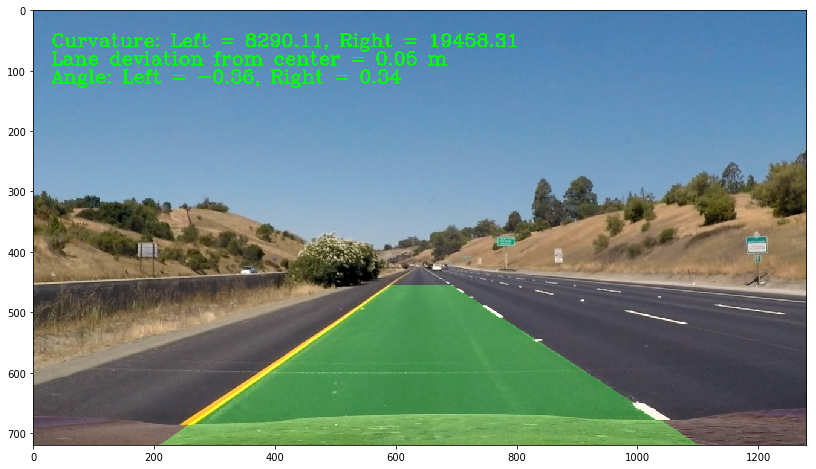

In [22]:
img = cv2.imread('./test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
left_fit = [] 
right_fit = []
first = True
result = pipeline(img)
plt.figure(figsize=(16,8))
plt.imshow(result)

In [44]:
#video pipeline
def pipeline2(img):
    global left_line
    global right_line
    obj_points, img_points = methods.read_points()
    undist = methods.cal_undistort(img, obj_points, img_points)
    corners = np.float32([[253, 697], [585, 456], [700, 456], [1061, 690]])
    new_top_left = np.array([corners[0, 0], 0])
    new_top_right = np.array([corners[3, 0], 0])
    offset = [50, 0]
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])
    tr_img, t_m, inv_m = methods.perspective_tr(undist, src, dst, (undist.shape[1], undist.shape[0]))
    binary_warped = score_pixels(tr_img)
    left_line.calculate(binary_warped)
    right_line.calculate(binary_warped)
    result = line.draw2(binary_warped, img, inv_m, left_line, right_line)
    return result

In [48]:
video_output = "output_images/project_video_output.mp4"
clip1 = VideoFileClip("project_video.mp4")
# clear lines
left_line = line.Line() 
right_line = line.Line()
right_line.left=False
clip1_output = clip1.fl_image(pipeline2) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4



 12%|█▏        | 152/1261 [01:34<11:39,  1.59it/s]


 24%|██▍       | 303/1261 [03:05<09:26,  1.69it/s]


 36%|███▌      | 454/1261 [04:39<07:53,  1.70it/s]


 48%|████▊     | 605/1261 [06:13<06:59,  1.56it/s]


 60%|█████▉    | 756/1261 [07:47<05:01,  1.68it/s]


 72%|███████▏  | 907/1261 [09:16<03:26,  1.71it/s]


 84%|████████▍ | 1057/1261 [10:45<02:04,  1.64it/s]


 96%|█████████▌| 1205/1261 [12:15<00:34,  1.63it/s]


100%|█████████▉| 1260/1261 [12:49<00:00,  1.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

CPU times: user 14min 37s, sys: 38.5 s, total: 15min 15s
Wall time: 12min 50s


In [49]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [47]:
video_challenge_output = "output_images/challenge_video_output.mp4"
clip1 = VideoFileClip("challenge_video.mp4")
# clear lines
left_line = line.Line() 
right_line = line.Line()
right_line.left=False
clip1_output = clip1.fl_image(pipeline2) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_challenge_output, audio=False)

[MoviePy] >>>> Building video output_images/challenge_video_output.mp4
[MoviePy] Writing video output_images/challenge_video_output.mp4


  4%|▎         | 18/485 [00:10<04:47,  1.62it/s]

KeyboardInterrupt: 

In [46]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_challenge_output))

In [149]:
video_challenge_output = "output_images/harder_challenge_video_output.mp4"
clip1 = VideoFileClip("harder_challenge_video.mp4")
# clear lines
left_line = line.Line() 
right_line = line.Line()
right_line.left=False
clip1_output = clip1.fl_image(pipeline2) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_challenge_output, audio=False)

[MoviePy] >>>> Building video output_images/harder_challenge_video_output.mp4
[MoviePy] Writing video output_images/harder_challenge_video_output.mp4



 13%|█▎        | 152/1200 [01:31<10:25,  1.68it/s]


 25%|██▌       | 303/1200 [03:07<09:56,  1.50it/s]


 38%|███▊      | 454/1200 [04:51<08:36,  1.44it/s]


 50%|█████     | 605/1200 [06:48<09:39,  1.03it/s]


 63%|██████▎   | 756/1200 [09:12<06:50,  1.08it/s]


 76%|███████▌  | 907/1200 [11:26<03:24,  1.43it/s]


 88%|████████▊ | 1057/1200 [13:16<01:59,  1.20it/s]


100%|█████████▉| 1199/1200 [15:32<00:00,  1.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/harder_challenge_video_output.mp4 

CPU times: user 16min 47s, sys: 59 s, total: 17min 46s
Wall time: 15min 33s


In [150]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_challenge_output))